In [1]:
import re
import typing as t
from collections import defaultdict
import csv
from pathlib import Path
from tqdm import tqdm

import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords, wordnet
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset, random_split

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
DATA_DIR = Path("data/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [4]:
def on_cuda(device: str) -> bool:
    return device == "cuda"


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        train_dataloader: DataLoader,
        epochs: int,
        test_dataloader: DataLoader = None,
        lr_scheduler=None,
        verbose: int = 100,
        device: str = "cpu",
) -> t.List[float]:
    train_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)
        train_loss = train_loop(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            verbose=verbose,
            device=device,
        )
        train_losses.append(train_loss.item())
        if test_dataloader:
            loss, acc = test_loop(test_dataloader, model, loss_fn, device=device)
            if lr_scheduler:
                lr_scheduler.step(loss)
        torch.cuda.empty_cache()
    return train_losses


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = 100,
        device: str = "cpu",
) -> torch.Tensor:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss = 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        avg_loss += loss
        if batch % verbose == 0:
            print(f"loss: {loss:>7f}  [{batch * len(x):>5d}/{size:>5d}]")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return avg_loss / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        avg_loss += loss_fn(pred, y)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # noqa

        del x, y, pred
        torch.cuda.empty_cache()

    avg_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {accuracy:>4f}, Avg loss: {avg_loss:>8f} \n")

    return avg_loss, accuracy


def train_test_split(dataset: t.Union[Dataset, t.Sized], train_part: float) -> t.Tuple[Subset, Subset]:
    train_size = round(train_part * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset


@torch.no_grad()
def get_y_test_y_pred(
        model: nn.Module,
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.hstack(y_test).detach().cpu(), torch.hstack(y_pred).detach().cpu()

## 1. Классификация фамилий (RNN)

Датасет: https://disk.yandex.ru/d/frNchuaBQVLxyA?w=1

1.1 Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть Элмана в виде класса `RNN`. Используя созданный класс `RNN`, решите задачу классификации фамилий. 


In [5]:
class RNN(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)

    def forward(self, inputs: torch.Tensor, hx: torch.Tensor = None):
        batch_size, sequence_size, _ = inputs.size()
        inputs = inputs.permute(1, 0, 2)  # для nn.RNNCell batch_size должен быть на 2-ой месте

        if hx is None:
            # так же скрытое состояние инициализируется в nn.RNN
            hx = torch.zeros(batch_size, self.hidden_size, dtype=inputs.dtype, device=inputs.device)
        else:
            # 1-ая размерность равная 1 для совместимости с nn.RNN
            hx = hx.squeeze(0)  # избавляемся от 1-ой размерности равной 1

        hidden = []
        for i in range(sequence_size):
            hx = self.rnn_cell(inputs[i], hx)
            hidden.append(hx)

        hidden = torch.stack(hidden)
        hx = hidden[-1].unsqueeze(0)
        return hidden.permute(1, 0, 2), hx

Проверка реализации RNN:

In [6]:
torch.manual_seed(0)

input_size, hidden_size = 4, 5
inputs = torch.randn(2, 3, input_size)
hx = torch.randn(1, 2, hidden_size)

torch.manual_seed(0)
my_rnn = RNN(input_size=input_size, hidden_size=hidden_size)

torch.manual_seed(0)
true_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)

In [7]:
my_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<PermuteBackward>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<UnsqueezeBackward0>))

In [8]:
true_rnn(inputs, hx)

(tensor([[[ 0.6515,  0.5430,  0.4023,  0.6325, -0.6068],
          [ 0.9149, -0.1088,  0.6385, -0.7387,  0.7532],
          [-0.6936,  0.5123, -0.2784, -0.5693, -0.0055]],
 
         [[ 0.1954,  0.6152,  0.2958, -0.8005,  0.8074],
          [-0.4577,  0.7566,  0.2972, -0.8834,  0.1265],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<TransposeBackward1>),
 tensor([[[-0.6936,  0.5123, -0.2784, -0.5693, -0.0055],
          [ 0.7166,  0.1516,  0.8047, -0.2007,  0.8192]]],
        grad_fn=<StackBackward>))

100% совпадение

In [9]:
class SurnamesRNNClassifier(nn.Module):

    def __init__(
            self,
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = RNN(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x, hx = self.rnn(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [10]:
class SurnamesVocab:
    pad = "<PAD>"

    def __init__(self, surnames: t.List[str]):
        uniques = set()
        max_len = 0
        for w in map(str.lower, surnames):
            uniques.update(w)
            max_len = max(len(w), max_len)

        self.alphabet = [self.pad, *uniques]
        self.max_len = max_len
        self.ch2i = {ch: i for i, ch in enumerate(self.alphabet)}

    def __len__(self):
        return len(self.alphabet)

    def encode(self, word: str) -> torch.Tensor:
        indices = [self.ch2i[ch] for ch in word]
        indices += [self.ch2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.ch2i[self.pad], as_tuple=True)[0]
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return "".join(self.alphabet[i] for i in indices)


class SurnamesDataset(Dataset):
    df: pd.DataFrame
    surnames: t.List[str]
    vocab: SurnamesVocab
    labeler: LabelEncoder
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path):
        self.df = pd.read_csv(path)

        self.surnames = self.df["surname"].tolist()
        self.vocab = SurnamesVocab(self.surnames)
        size = self.vocab.encode(self.surnames[0].lower()).size()
        data = torch.vstack([self.vocab.encode(w.lower()) for w in self.surnames])
        self.data = data.view(len(self.surnames), *size)

        self.labeler = LabelEncoder()
        targets = self.labeler.fit_transform(self.df["nationality"])
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, word: str) -> torch.Tensor:
        return self.vocab.encode(word)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [11]:
surnames_dataset = SurnamesDataset(DATA_DIR / "surnames.csv")
len(surnames_dataset)

10980

In [12]:
torch.manual_seed(0)

train_surnames_dataset, test_surnames_dataset = train_test_split(surnames_dataset, train_part=0.8)
print(len(train_surnames_dataset), len(test_surnames_dataset))

8784 2196


### Handmade RNN

In [13]:
torch.manual_seed(0)

handmade_rnn_net = SurnamesRNNClassifier(
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(handmade_rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [14]:
%%time

_ = common_train(
    epochs=20,
    model=handmade_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.871371  [    0/ 8784]
loss: 1.428667  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.635701, Avg loss: 1.257843 

Epoch 2
--------------------------------
loss: 1.134080  [    0/ 8784]
loss: 1.171728  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.691257, Avg loss: 1.047224 

Epoch 3
--------------------------------
loss: 0.981887  [    0/ 8784]
loss: 0.838968  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.718124, Avg loss: 0.958215 

Epoch 4
--------------------------------
loss: 0.826575  [    0/ 8784]
loss: 0.806086  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.739982, Avg loss: 0.901430 

Epoch 5
--------------------------------
loss: 0.690964  [    0/ 8784]
loss: 0.937260  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.742714, Avg loss: 0.871603 

Epoch 6
--------------------------------
loss: 0.737858  [    0/ 8784]
loss: 0.567542  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.753188, Avg loss: 0.869683 

Epoch 7
--------------------------------
loss: 0.566065  [    0/

In [15]:
y_test, y_pred = get_y_test_y_pred(handmade_rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.97      1.00      0.99       340
     Chinese       0.70      0.74      0.72        38
       Czech       0.58      0.31      0.41        96
       Dutch       0.72      0.41      0.53        51
     English       0.71      0.85      0.77       573
      French       0.20      0.10      0.14        39
      German       0.57      0.51      0.54       121
       Greek       0.75      0.62      0.68        34
       Irish       0.58      0.30      0.39        37
     Italian       0.72      0.77      0.75       128
    Japanese       0.80      0.90      0.85       156
      Korean       0.22      0.20      0.21        10
      Polish       0.60      0.46      0.52        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.86      0.88      0.87       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.43      0.38      0.40        50
  Vietnamese       0.50    

1.2 Замените модуль `RNN` из 1.1 на модули `nn.RNN`, `nn.LSTM` и `nn.GRU` (не забудьте указать аргумент `batch_first=True`). Сравните результаты работы.

In [16]:
class SurnamesAutobotRNNClassifier(nn.Module):

    def __init__(
            self,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            num_embeddings: int,
            embedding_dim: int,
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.cx = cx.detach()
            self.hx = hx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

### nn.RNN

In [17]:
torch.manual_seed(0)

rnn_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.RNN,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [18]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.867698  [    0/ 8784]
loss: 1.622730  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.576503, Avg loss: 1.452961 

Epoch 2
--------------------------------
loss: 1.343994  [    0/ 8784]
loss: 1.309450  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.643898, Avg loss: 1.214564 

Epoch 3
--------------------------------
loss: 1.136298  [    0/ 8784]
loss: 0.985533  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.668033, Avg loss: 1.117155 

Epoch 4
--------------------------------
loss: 1.034030  [    0/ 8784]
loss: 0.907188  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.685337, Avg loss: 1.039520 

Epoch 5
--------------------------------
loss: 0.867153  [    0/ 8784]
loss: 1.092656  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.712204, Avg loss: 1.004628 

Epoch 6
--------------------------------
loss: 0.896041  [    0/ 8784]
loss: 0.793838  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.717668, Avg loss: 0.964900 

Epoch 7
--------------------------------
loss: 0.617007  [    0/

In [19]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.69      0.66      0.68        38
       Czech       0.36      0.22      0.27        96
       Dutch       0.76      0.43      0.55        51
     English       0.67      0.85      0.75       573
      French       0.21      0.08      0.11        39
      German       0.55      0.47      0.51       121
       Greek       0.60      0.53      0.56        34
       Irish       0.56      0.27      0.36        37
     Italian       0.64      0.69      0.66       128
    Japanese       0.84      0.86      0.85       156
      Korean       0.13      0.20      0.16        10
      Polish       0.55      0.46      0.50        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.85      0.84      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.44      0.32      0.37        50
  Vietnamese       0.25    

### nn.LSTM

In [20]:
torch.manual_seed(0)

lstm_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.LSTM,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [21]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.881627  [    0/ 8784]
loss: 1.897253  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.548270, Avg loss: 1.575520 

Epoch 2
--------------------------------
loss: 1.446818  [    0/ 8784]
loss: 1.583484  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.622951, Avg loss: 1.298717 

Epoch 3
--------------------------------
loss: 1.327830  [    0/ 8784]
loss: 1.244951  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.658925, Avg loss: 1.151080 

Epoch 4
--------------------------------
loss: 1.028336  [    0/ 8784]
loss: 1.087917  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.684426, Avg loss: 1.079769 

Epoch 5
--------------------------------
loss: 1.016642  [    0/ 8784]
loss: 0.972635  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.694444, Avg loss: 1.021266 

Epoch 6
--------------------------------
loss: 0.997646  [    0/ 8784]
loss: 0.899113  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.711293, Avg loss: 0.972107 

Epoch 7
--------------------------------
loss: 0.799433  [    0/

In [22]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.94      1.00      0.97       340
     Chinese       0.73      0.71      0.72        38
       Czech       0.71      0.25      0.37        96
       Dutch       0.68      0.33      0.45        51
     English       0.68      0.88      0.77       573
      French       0.10      0.03      0.04        39
      German       0.58      0.40      0.47       121
       Greek       0.62      0.47      0.53        34
       Irish       0.77      0.27      0.40        37
     Italian       0.62      0.70      0.65       128
    Japanese       0.84      0.83      0.84       156
      Korean       0.14      0.10      0.12        10
      Polish       0.55      0.42      0.48        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.83      0.87      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.48      0.44      0.46        50
  Vietnamese       0.00    

### nn.GRU

In [23]:
torch.manual_seed(0)

gru_net = SurnamesAutobotRNNClassifier(
    rnn_cls=nn.GRU,
    num_embeddings=len(surnames_dataset.vocab),
    embedding_dim=128,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [24]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.882524  [    0/ 8784]
loss: 1.701462  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.555556, Avg loss: 1.564122 

Epoch 2
--------------------------------
loss: 1.729184  [    0/ 8784]
loss: 1.257021  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.619763, Avg loss: 1.277214 

Epoch 3
--------------------------------
loss: 1.238291  [    0/ 8784]
loss: 1.264170  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.653461, Avg loss: 1.164596 

Epoch 4
--------------------------------
loss: 1.100605  [    0/ 8784]
loss: 1.004837  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.687614, Avg loss: 1.076801 

Epoch 5
--------------------------------
loss: 1.068239  [    0/ 8784]
loss: 0.889830  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.698998, Avg loss: 1.016363 

Epoch 6
--------------------------------
loss: 0.863274  [    0/ 8784]
loss: 0.725156  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.716302, Avg loss: 0.972016 

Epoch 7
--------------------------------
loss: 0.775604  [    0/

In [25]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.71      0.76      0.73        38
       Czech       0.52      0.26      0.35        96
       Dutch       0.76      0.43      0.55        51
     English       0.67      0.86      0.76       573
      French       0.12      0.08      0.09        39
      German       0.61      0.43      0.50       121
       Greek       0.61      0.50      0.55        34
       Irish       0.53      0.22      0.31        37
     Italian       0.64      0.67      0.66       128
    Japanese       0.87      0.84      0.85       156
      Korean       0.33      0.30      0.32        10
      Polish       0.62      0.31      0.41        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.82      0.87      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.50      0.34      0.40        50
  Vietnamese       1.00    

1.3 Загрузите предобученные эмбеддинги (https://disk.yandex.ru/d/BHuT2tEXr_yBOQ?w=1) в модуль `nn.Embedding` и обучите модели из 1.2.

In [26]:
class SurnamesDecepticonRNNClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [27]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.50d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.ones(len(surnames_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, ch in enumerate(surnames_dataset.vocab.alphabet):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[ch].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

(Embedding(56, 50, padding_idx=0), 5)

### nn.RNN

In [28]:
torch.manual_seed(0)

rnn_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [29]:
%%time

_ = common_train(
    epochs=20,
    model=rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.844056  [    0/ 8784]
loss: 1.961889  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.467213, Avg loss: 1.822342 

Epoch 2
--------------------------------
loss: 1.779048  [    0/ 8784]
loss: 1.709585  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.549180, Avg loss: 1.583308 

Epoch 3
--------------------------------
loss: 1.586961  [    0/ 8784]
loss: 1.536344  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.590619, Avg loss: 1.432243 

Epoch 4
--------------------------------
loss: 1.422195  [    0/ 8784]
loss: 1.295004  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.619763, Avg loss: 1.315370 

Epoch 5
--------------------------------
loss: 1.026811  [    0/ 8784]
loss: 1.261107  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.653005, Avg loss: 1.213327 

Epoch 6
--------------------------------
loss: 1.207651  [    0/ 8784]
loss: 1.371465  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.664390, Avg loss: 1.174516 

Epoch 7
--------------------------------
loss: 1.001609  [    0/

In [30]:
y_test, y_pred = get_y_test_y_pred(rnn_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.95      1.00      0.97       340
     Chinese       0.68      0.89      0.77        38
       Czech       0.44      0.17      0.24        96
       Dutch       0.73      0.22      0.33        51
     English       0.64      0.91      0.75       573
      French       0.29      0.05      0.09        39
      German       0.57      0.26      0.36       121
       Greek       0.63      0.50      0.56        34
       Irish       0.70      0.19      0.30        37
     Italian       0.60      0.73      0.66       128
    Japanese       0.77      0.87      0.82       156
      Korean       0.33      0.10      0.15        10
      Polish       0.41      0.35      0.38        26
  Portuguese       1.00      0.00      0.00         9
     Russian       0.86      0.84      0.85       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.40      0.16      0.23        50
  Vietnamese       1.00    

### nn.LSTM

In [31]:
torch.manual_seed(0)

lstm_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [32]:
%%time

_ = common_train(
    epochs=20,
    model=lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.900342  [    0/ 8784]
loss: 2.213569  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.427596, Avg loss: 1.954141 

Epoch 2
--------------------------------
loss: 2.058177  [    0/ 8784]
loss: 1.854866  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.525046, Avg loss: 1.634154 

Epoch 3
--------------------------------
loss: 1.752625  [    0/ 8784]
loss: 1.598981  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.575137, Avg loss: 1.473715 

Epoch 4
--------------------------------
loss: 1.504472  [    0/ 8784]
loss: 1.431903  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.615209, Avg loss: 1.337168 

Epoch 5
--------------------------------
loss: 1.181609  [    0/ 8784]
loss: 1.336328  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.648907, Avg loss: 1.247855 

Epoch 6
--------------------------------
loss: 1.225144  [    0/ 8784]
loss: 1.040383  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.665756, Avg loss: 1.151511 

Epoch 7
--------------------------------
loss: 0.961408  [    0/

In [33]:
y_test, y_pred = get_y_test_y_pred(lstm_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.96      1.00      0.98       340
     Chinese       0.78      0.82      0.79        38
       Czech       0.51      0.24      0.33        96
       Dutch       0.81      0.33      0.47        51
     English       0.64      0.89      0.74       573
      French       0.16      0.08      0.10        39
      German       0.50      0.37      0.43       121
       Greek       0.68      0.44      0.54        34
       Irish       0.67      0.16      0.26        37
     Italian       0.69      0.67      0.68       128
    Japanese       0.84      0.82      0.83       156
      Korean       0.25      0.20      0.22        10
      Polish       0.67      0.31      0.42        26
  Portuguese       0.00      0.00      0.00         9
     Russian       0.83      0.84      0.83       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.47      0.32      0.38        50
  Vietnamese       0.67    

### nn.GRU

In [34]:
torch.manual_seed(0)

gru_net = SurnamesDecepticonRNNClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=surnames_dataset.vocab.max_len,
    num_classes=len(surnames_dataset.labeler.classes_),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_net.parameters(), lr=0.0015)

train_dataloader = DataLoader(train_surnames_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_surnames_dataset, batch_size=512)

In [35]:
%%time

_ = common_train(
    epochs=20,
    model=gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    verbose=50,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 2.875406  [    0/ 8784]
loss: 1.868236  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.447177, Avg loss: 1.894630 

Epoch 2
--------------------------------
loss: 1.732831  [    0/ 8784]
loss: 1.549724  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.535974, Avg loss: 1.594002 

Epoch 3
--------------------------------
loss: 1.401428  [    0/ 8784]
loss: 1.449472  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.586976, Avg loss: 1.437853 

Epoch 4
--------------------------------
loss: 1.214180  [    0/ 8784]
loss: 1.418058  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.624772, Avg loss: 1.306517 

Epoch 5
--------------------------------
loss: 1.270644  [    0/ 8784]
loss: 1.450443  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.642532, Avg loss: 1.223909 

Epoch 6
--------------------------------
loss: 1.351915  [    0/ 8784]
loss: 1.343317  [ 6400/ 8784]
Test Error: 
 Accuracy: 0.675319, Avg loss: 1.145013 

Epoch 7
--------------------------------
loss: 0.985525  [    0/

In [36]:
y_test, y_pred = get_y_test_y_pred(gru_net, test_dataloader, DEVICE)

print(metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred,
    target_names=surnames_dataset.labeler.classes_,
    zero_division=True,
))

              precision    recall  f1-score   support

      Arabic       0.94      1.00      0.97       340
     Chinese       0.75      0.71      0.73        38
       Czech       0.46      0.20      0.28        96
       Dutch       0.61      0.22      0.32        51
     English       0.66      0.87      0.75       573
      French       0.14      0.05      0.08        39
      German       0.59      0.40      0.47       121
       Greek       0.50      0.44      0.47        34
       Irish       0.92      0.30      0.45        37
     Italian       0.66      0.75      0.70       128
    Japanese       0.75      0.87      0.81       156
      Korean       0.13      0.20      0.16        10
      Polish       0.50      0.23      0.32        26
  Portuguese       0.50      0.11      0.18         9
     Russian       0.85      0.83      0.84       458
    Scottish       0.00      0.00      0.00        17
     Spanish       0.41      0.30      0.34        50
  Vietnamese       0.50    

## 2. Классификация новостей на основе заголовка

Датасет: https://disk.yandex.ru/d/FN-EgWGIpyjLxQ?w=1

Эмбеддинги: https://nlp.stanford.edu/projects/glove/ (находите ссылку на архив
glove.6B.zip, в нем несколько файлов с эмбеддингами слов, выбираете один из файлов в
архиве)

2.1 Загрузите набор данных train.csv. Выполните предобработку столбца Title

2.2 На основе этих данных создайте датасет NewsDataset . Не забудьте добавить
специальные токены `<PAD>` для дополнения последовательностей до нужной длины и
`<UNK>` для корректной обработке ранее не встречавшихся токенов. В данной задаче
рассматривайте отдельные слова как токены. Разбейте датасет на обучающее и
валидационное множество.

In [50]:
PATTERN = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def simple_preprocess_news_title(title: str) -> str:
    return title.lower()


def complex_preprocess_news_title(
        title: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    title = simple_preprocess_news_title(title)
    title = PATTERN.sub(" ", title)

    words = []
    for word in nltk.word_tokenize(title):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)

In [51]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


_snowball_stemmer = nltk.SnowballStemmer(language="english")


def snowball_stemmer(token: str) -> str:
    return _snowball_stemmer.stem(token)

In [52]:
class NewsVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, news_titles: t.List[str], max_len: int = 0):
        uniques = set()
        for title in news_titles:
            words = nltk.word_tokenize(title)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, review: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(review)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)


class NewsDataset(Dataset):
    df: pd.DataFrame
    titles: t.List[str]
    classes: t.List[int]
    vocab: NewsVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, path: Path, preprocess: t.Callable[[str], str], title_max_len: int = 0):
        self.df = pd.read_csv(path)

        self.titles = self.df["Title"].apply(preprocess).tolist()
        self.vocab = NewsVocab(self.titles, max_len=title_max_len)

        self.data = torch.vstack([self.vocab.encode(w.lower()) for w in self.titles])
        self.targets = torch.tensor(self.df["Class Index"].to_numpy(), dtype=torch.long) - 1
        self.classes = self.targets.unique().tolist()

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def encode(self, title: str) -> torch.Tensor:
        return self.vocab.encode(title)

    def decode(self, indices: torch.Tensor) -> str:
        return self.vocab.decode(indices)

In [53]:
def preprocess_news_title(title: str) -> str:
    return complex_preprocess_news_title(title, lemmatizer_or_stemmer=snowball_stemmer, min_word_len=3)


train_news_dataset = NewsDataset(
    DATA_DIR / "news/train.csv",
    preprocess_news_title,
)
test_news_dataset = NewsDataset(
    DATA_DIR / "news/test.csv",
    preprocess_news_title,
    title_max_len=train_news_dataset.vocab.max_len,
)
len(train_news_dataset), len(test_news_dataset)

(120000, 7600)

In [54]:
train_news_dataloader = DataLoader(train_news_dataset, batch_size=256, shuffle=True)
test_news_dataloader = DataLoader(test_news_dataset, batch_size=512)

2.3 Создайте модель для классификации, используя слой nn.Embedding и слой nn.RNN.
эмбеддинги инициализируйте случайным образом не забудьте указать аргумент padding_idx для nn.Embedding

In [55]:
class NewsClassifier(nn.Module):

    def __init__(
            self,
            embedding: nn.Embedding,
            rnn_cls: t.Union[t.Type[nn.RNN], t.Type[nn.LSTM], t.Type[nn.GRU]],
            rnn_hidden_size: int,
            vector_size: int,
            num_classes: int,
    ):
        super().__init__()
        self.embedding = embedding
        self.hx, self.cx = None, None
        self.rnn = rnn_cls(input_size=self.embedding.embedding_dim, hidden_size=rnn_hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )

    def reset_rnn_state(self):
        self.hx, self.cx = None, None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)

        if isinstance(self.rnn, (nn.RNN, nn.GRU)):
            x, hx = self.rnn(x, self.hx)
            self.hx = hx.detach()
        else:
            if self.hx is not None and self.cx is not None:
                hx_cx = (self.hx, self.cx)
            else:
                hx_cx = None
            x, (hx, cx) = self.rnn(x, hx_cx)
            self.hx = hx.detach()
            self.cx = cx.detach()

        x = torch.flatten(x, 1)
        return self.classifier(x)

In [56]:
torch.manual_seed(0)

news_rnn_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_net.parameters(), lr=0.001)

In [57]:
%%time

_ = common_train(
    epochs=5,
    model=news_rnn_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=500,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.399165  [    0/120000]
Test Error: 
 Accuracy: 0.262105, Avg loss: 1.840470 

Epoch 2
--------------------------------
loss: 0.785680  [    0/120000]
Test Error: 
 Accuracy: 0.259474, Avg loss: 2.033921 

Epoch 3
--------------------------------
loss: 0.548066  [    0/120000]
Test Error: 
 Accuracy: 0.256842, Avg loss: 2.154701 

Epoch 4
--------------------------------
loss: 0.433791  [    0/120000]
Test Error: 
 Accuracy: 0.259342, Avg loss: 2.363977 

Epoch 5
--------------------------------
loss: 0.323912  [    0/120000]
Test Error: 
 Accuracy: 0.258158, Avg loss: 2.609166 

CPU times: user 40 s, sys: 6.19 s, total: 46.2 s
Wall time: 47.4 s


2.4 Переобучите модель, заменив слой nn.RNN на nn.LSTM и nn.GRU . Сравните качество
на тестовой выборке. Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [58]:
torch.manual_seed(0)

news_lstm_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_net.parameters(), lr=0.001)

In [59]:
%%time

_ = common_train(
    epochs=5,
    model=news_lstm_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=500,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.387967  [    0/120000]
Test Error: 
 Accuracy: 0.255921, Avg loss: 1.798040 

Epoch 2
--------------------------------
loss: 0.540377  [    0/120000]
Test Error: 
 Accuracy: 0.263421, Avg loss: 1.980840 

Epoch 3
--------------------------------
loss: 0.448271  [    0/120000]
Test Error: 
 Accuracy: 0.263684, Avg loss: 2.149188 

Epoch 4
--------------------------------
loss: 0.301585  [    0/120000]
Test Error: 
 Accuracy: 0.256447, Avg loss: 2.383534 

Epoch 5
--------------------------------
loss: 0.378154  [    0/120000]
Test Error: 
 Accuracy: 0.257632, Avg loss: 2.515698 

CPU times: user 39.1 s, sys: 5.88 s, total: 45 s
Wall time: 46 s


In [60]:
torch.manual_seed(0)

news_gru_net = NewsClassifier(
    embedding=nn.Embedding(num_embeddings=len(train_news_dataset.vocab), embedding_dim=64, padding_idx=0),
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_net.parameters(), lr=0.001)

In [61]:
%%time

_ = common_train(
    epochs=5,
    model=news_gru_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=500,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.384754  [    0/120000]
Test Error: 
 Accuracy: 0.257632, Avg loss: 1.757510 

Epoch 2
--------------------------------
loss: 0.617294  [    0/120000]
Test Error: 
 Accuracy: 0.260789, Avg loss: 1.953100 

Epoch 3
--------------------------------
loss: 0.537489  [    0/120000]
Test Error: 
 Accuracy: 0.262895, Avg loss: 2.082329 

Epoch 4
--------------------------------
loss: 0.386451  [    0/120000]
Test Error: 
 Accuracy: 0.260658, Avg loss: 2.183148 

Epoch 5
--------------------------------
loss: 0.410345  [    0/120000]
Test Error: 
 Accuracy: 0.259211, Avg loss: 2.296090 

CPU times: user 39.2 s, sys: 6.32 s, total: 45.5 s
Wall time: 46.7 s


2.5 Выполните пункты 2.3 и 2.4, используя предобученные эмбеддинги Glove.
Прокомментируйте результат.
Эмбеддинги из скачанного файла загрузите в виде двумерного тензора pretrained_embeddings.
Обратите внимание, что номер строки в этом тензоре должен соответствовать
токену (слову), имеющему такой индекс в вашем словаре.
для слов, которых нет в файле с эмбеддингами, инициализуйте эмбеддинг
случайным образом

In [62]:
torch.manual_seed(0)

embedding_weights = pd.read_csv(
    DATA_DIR / "glove.6B/glove.6B.100d.txt",
    sep=" ",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    header=None,
)

weights = torch.empty(len(train_news_dataset.vocab), embedding_weights.shape[1], dtype=torch.float32)
torch.nn.init.normal_(weights)

miss = 0
for i, w in tqdm(enumerate(train_news_dataset.vocab.alphabet), total=len(train_news_dataset.vocab.alphabet)):
    try:
        weights[i] = torch.from_numpy(embedding_weights.loc[w].to_numpy())
    except KeyError:
        miss += 1

embedding = nn.Embedding.from_pretrained(weights, padding_idx=0)
embedding, miss

100%|██████████| 21963/21963 [01:55<00:00, 189.74it/s]


(Embedding(21963, 100, padding_idx=0), 6143)

In [63]:
torch.manual_seed(0)

news_rnn_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.RNN,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_rnn_pretrained_net.parameters(), lr=0.001)

In [64]:
%%time

_ = common_train(
    epochs=5,
    model=news_rnn_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=500,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.384148  [    0/120000]
Test Error: 
 Accuracy: 0.240395, Avg loss: 2.024677 

Epoch 2
--------------------------------
loss: 0.680559  [    0/120000]
Test Error: 
 Accuracy: 0.240789, Avg loss: 2.103679 

Epoch 3
--------------------------------
loss: 0.643991  [    0/120000]
Test Error: 
 Accuracy: 0.235658, Avg loss: 2.202144 

Epoch 4
--------------------------------
loss: 0.633764  [    0/120000]
Test Error: 
 Accuracy: 0.236053, Avg loss: 2.255651 

Epoch 5
--------------------------------
loss: 0.578327  [    0/120000]
Test Error: 
 Accuracy: 0.233684, Avg loss: 2.311034 

CPU times: user 36.4 s, sys: 3.29 s, total: 39.7 s
Wall time: 40 s


In [65]:
torch.manual_seed(0)

news_lstm_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.LSTM,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_lstm_pretrained_net.parameters(), lr=0.001)

In [66]:
%%time

_ = common_train(
    epochs=5,
    model=news_lstm_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=500,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.384447  [    0/120000]
Test Error: 
 Accuracy: 0.241316, Avg loss: 1.992097 

Epoch 2
--------------------------------
loss: 0.578082  [    0/120000]
Test Error: 
 Accuracy: 0.241579, Avg loss: 2.273448 

Epoch 3
--------------------------------
loss: 0.334912  [    0/120000]
Test Error: 
 Accuracy: 0.246579, Avg loss: 2.456173 

Epoch 4
--------------------------------
loss: 0.458666  [    0/120000]
Test Error: 
 Accuracy: 0.245132, Avg loss: 2.498301 

Epoch 5
--------------------------------
loss: 0.427835  [    0/120000]
Test Error: 
 Accuracy: 0.249868, Avg loss: 2.628455 

CPU times: user 39.3 s, sys: 3.42 s, total: 42.7 s
Wall time: 43 s


In [67]:
torch.manual_seed(0)

news_gru_pretrained_net = NewsClassifier(
    embedding=embedding,
    rnn_cls=nn.GRU,
    rnn_hidden_size=64,
    vector_size=train_news_dataset.vocab.max_len,
    num_classes=len(train_news_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(news_gru_pretrained_net.parameters(), lr=0.001)

In [68]:
%%time

_ = common_train(
    epochs=5,
    model=news_gru_pretrained_net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_news_dataloader,
    test_dataloader=test_news_dataloader,
    verbose=500,
    device=DEVICE,
)

Epoch 1
--------------------------------
loss: 1.386531  [    0/120000]
Test Error: 
 Accuracy: 0.235395, Avg loss: 1.919036 

Epoch 2
--------------------------------
loss: 0.554642  [    0/120000]
Test Error: 
 Accuracy: 0.237368, Avg loss: 2.109704 

Epoch 3
--------------------------------
loss: 0.470054  [    0/120000]
Test Error: 
 Accuracy: 0.235921, Avg loss: 2.188451 

Epoch 4
--------------------------------
loss: 0.548236  [    0/120000]
Test Error: 
 Accuracy: 0.243684, Avg loss: 2.385556 

Epoch 5
--------------------------------
loss: 0.535775  [    0/120000]
Test Error: 
 Accuracy: 0.248421, Avg loss: 2.428009 

CPU times: user 36.5 s, sys: 3.82 s, total: 40.3 s
Wall time: 40.7 s


Результаты сведите в таблицу (модель/метрика качества на тестовом множестве).

In [69]:
def make_pivot_table(
        models: t.List[t.Tuple[str, NewsClassifier]],
        test_dataloader: DataLoader,
        device: str = "cpu",
) -> pd.DataFrame:
    general_report = {}
    for name, model in models:
        report = {}
        y_test, y_pred = get_y_test_y_pred(model, test_dataloader, device)
        ms = metrics.classification_report(y_test, y_pred, zero_division=True, output_dict=True)
        report["accuracy"] = ms["accuracy"]
        report["precision (w avg)"] = ms["weighted avg"]["precision"]
        report["recall (w avg)"] = ms["weighted avg"]["recall"]
        report["f1-score (w avg)"] = ms["weighted avg"]["f1-score"]
        general_report[name] = report
    return pd.DataFrame(general_report)

In [70]:
report = make_pivot_table(
    [
        ("RNN", news_rnn_net),
        ("LSTM", news_lstm_net),
        ("GRU", news_gru_net),
        ("RNN (pretrained)", news_rnn_pretrained_net),
        ("LSTM (pretrained)", news_lstm_pretrained_net),
        ("GRU (pretrained)", news_gru_pretrained_net),
    ],
    test_news_dataloader,
    DEVICE,
)
report

,RNN,LSTM,GRU,RNN (pretrained),LSTM (pretrained),GRU (pretrained)
accuracy,0.258158,0.257632,0.259211,0.233684,0.249868,0.248289
precision (w avg),0.256169,0.257710,0.259789,0.228780,0.245715,0.243924
recall (w avg),0.258158,0.257632,0.259211,0.233684,0.249868,0.248289
f1-score (w avg),0.248798,0.251148,0.253172,0.224777,0.241715,0.234514


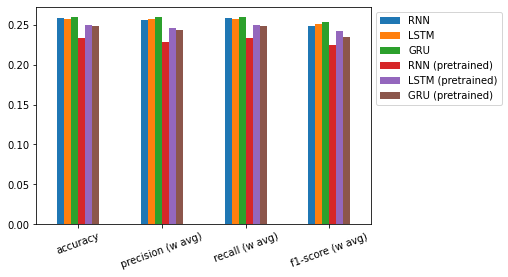

In [71]:
import matplotlib.pyplot as plt

ax = report.plot.bar(rot=20)
ax.legend(loc="upper left", bbox_to_anchor=(1,1));